In [107]:
import sys
import os
sys.path.append('.'+'/fivepoint')
import build.fivep as f
import time
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from spherical_distortion.functional import create_tangent_images, unresample
from spherical_distortion.util import *
import matplotlib.pyplot as plt
from skimage import io
import os
import cv2

import sys
import pandas as pd
import numpy as np
import _spherical_distortion_ext._mesh as _mesh
import argparse
from PIL import Image
import random

from random import sample
import imageio
from scipy.spatial.transform import Rotation as Rot

from utils.coord    import coord_3d
from utils.ransac   import *
from utils.keypoint import *
from utils.metrics  import *
from utils.camera_recovering import *
from utils.matching import *

from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm
from torchvision import transforms


sys.path.append('.'+'/SPHORB-master')

import build1.sphorb_cpp as sphorb

#sys.path.append('..')
#from SuperGluePretrainedNetwork.models.matching import Matching

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from SuperGluePretrainedNetwork.models.superpoint import SuperPoint
from SuperGluePretrainedNetwork.models.superglue import SuperGlue

from LightGlue.lightglue import LightGlue, SuperPoint, DISK
from LightGlue.lightglue.utils import load_image, rbd
from LightGlue.lightglue import viz2d

sys.path.append('.'+'/SphereGlue')
from SphereGlue.model.sphereglue import SphereGlue
from SphereGlue.utils.demo_mydataset import MyDataset 

In [108]:
def plot_matches(image0,
                 image1,
                 kpts0,
                 kpts1,
                 x1,
                 x2,
                 inlier_idx,
                 radius=2):
    
    # Convert the bool list of inlier_idx to integer values.
    match_true = np.array(inlier_idx, dtype=int)
  
    out0 = plot_keypoints(image0, kpts0, radius, (255, 0, 0))
    out1 = plot_keypoints(image1, kpts1, radius, (255, 0, 0))

    H0, W0 = image0.shape[0], image0.shape[1]
    H1, W1 = image1.shape[0], image1.shape[1]

    H, W = H0 + H1, max(W0, W1)
    out = 255 * np.ones((H, W, 3), np.uint8)
    out[:H0, :W0, :] = out0
    out[H0:H0+H1, :W1, :] = out1

    mkpts0, mkpts1 = x1, x2
    mkpts0 = np.round(mkpts0).astype(int)
    mkpts1 = np.round(mkpts1).astype(int)

    mkpts1[:, 1] += H0
    
    for kpt0, kpt1, mt in zip(mkpts0, mkpts1, match_true):
        (x0, y0), (x1, y1) = kpt0, kpt1
        mcolor = (0, 0, 255) if mt == 0 else (0, 255, 0)  # Red for outliers, Green for inliers
        cv2.line(out, (x0, y0), (x1, y1),
                 color=mcolor,
                 thickness=2,
                 lineType=cv2.LINE_AA)

    return out



def plot_keypoints(image, kpts, radius=2, color=(0, 0, 255)):
    if image.dtype is not np.dtype('uint8'):
        image = image * 255
        image = image.astype(np.uint8)

    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    out = np.ascontiguousarray(image.copy())
    kpts = np.round(kpts).astype(int)

    for kpt in kpts:
        x0, y0 = kpt
        cv2.circle(out, (x0, y0), 4, color, -1, lineType=cv2.LINE_4)
    return out


In [130]:
def mnn_matcher2(desc1, desc2, use_new_method):
    d1_square = np.sum(np.square(desc1), axis=1, keepdims=True)
    d2_square = np.sum(np.square(desc2), axis=1, keepdims=True)
    distances = np.sqrt(d1_square - 2 * np.dot(desc1, desc2.T) + d2_square.T)
    distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    if use_new_method == 1:
        dec = 1
    elif use_new_method == 2:
        dec = 0.1
    elif use_new_method == 3:
        dec = 0.5
    elif use_new_method == 4:
        dec = 3
    elif use_new_method == 5:
        dec = 5
    elif use_new_method == 6:
        dec = 10
    elif use_new_method == 7:
        dec = 100
    elif use_new_method == 8:
        dec = 2
    elif use_new_method == 9:
        dec = 4
    threshold = np.percentile(distances, dec) 
    distances[distances > threshold] = np.max(distances)
    #print("border:", threshold)

    nn12 = np.argmin(distances, axis=1)
    nn21 = np.argmin(distances, axis=0)
    ids1 = np.arange(0, distances.shape[0])
    mask = (ids1 == nn21[nn12])
    matches = np.stack([ids1[mask], nn12[mask]])

    return matches.transpose()


def mnn_matcher_new2(desc1, desc2, use_new_method):
    d1_square = np.sum(np.square(desc1), axis=1, keepdims=True)
    d2_square = np.sum(np.square(desc2), axis=1, keepdims=True)
    distances = np.sqrt(d1_square - 2 * np.dot(desc1, desc2.T) + d2_square.T)
    distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    nn12 = np.argmin(distances, axis=1)
    nn21 = np.argmin(distances, axis=0)
    ids1 = np.arange(0, distances.shape[0])
    mask = (ids1 == nn21[nn12])
    matches = np.stack([ids1[mask], nn12[mask]])
    matched_distances = distances[ids1[mask], nn12[mask]]

    matches_with_distances = np.hstack([matches.transpose(), matched_distances[:, np.newaxis]])
    sorted_matches_with_distances = matches_with_distances[matches_with_distances[:, 2].argsort()]
    if use_new_method == 1001:
        dec = 0.1
    if use_new_method == 1002:
        dec = 0.05
    if use_new_method == 1003:
        dec = 0.2
    if use_new_method == 1004:
        dec = 0.3
    if use_new_method == 10001:
        dec = 0.1
    if use_new_method == 10002:
        dec = 0.05
    if use_new_method == 10003:
        dec = 0.2
    if use_new_method == 10004:
        dec = 0.3
    num_to_remove = int(len(sorted_matches_with_distances) * dec)
    matches = sorted_matches_with_distances[:-num_to_remove, :2].transpose().astype(int)
    #print("border:", sorted_matches_with_distances[-num_to_remove-1:-num_to_remove, :])
    plt.figure(figsize=(10, 6))
    plt.hist(matched_distances, bins="auto", alpha=0.75, color='skyblue')
    plt.title('Data Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    plt.show()

    return matches.transpose()


def matched_points2(pts1, pts2, desc1, desc2, opt, args_opt, match='ratio', use_new_method=0):
    if opt[-1] == 'p':
        porce = int(opt[:-1])
        n_key = int(porce/100 * pts1.shape[0])
    else:
        n_key = int(opt)

    s_pts1  = pts1.copy()[:n_key,:]
    s_pts2  = pts2.copy()[:n_key,:]
    s_desc1 = desc1.copy().astype('float32')[:n_key,:]
    s_desc2 = desc2.copy().astype('float32')[:n_key,:]

    if 'orb' in args_opt:
        s_desc1 = s_desc1.astype(np.uint8)
        s_desc2 = s_desc2.astype(np.uint8)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, True)
        matches = bf.match(s_desc1, s_desc2)
    elif use_new_method in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
        matches_idx = mnn_matcher2(s_desc1, s_desc2, use_new_method)
        matches = [cv2.DMatch(i, j, 0) for i, j in matches_idx]
    elif use_new_method in [1001, 1002, 1003, 1004, 10001, 10002, 10003, 10004]:
        matches_idx = mnn_matcher_new2(s_desc1, s_desc2, use_new_method)
        matches = [cv2.DMatch(i, j, 0) for i, j in matches_idx]
    elif use_new_method == 10:
        thresh = 0.75
        bf = cv2.BFMatcher(cv2.NORM_L2, False)
        matches1 = bf.knnMatch(s_desc1,s_desc2, k=2)
        matches2 = bf.knnMatch(s_desc2,s_desc1, k=2)
        good1 = []
        for m, n in matches1:
            if m.distance < thresh * n.distance:
                good1.append(m)
        good2 = []
        for m, n in matches2:
            if m.distance < thresh * n.distance:
                good2.append(m)
        good = []
        for m1 in good1:
            for m2 in good2:
                if m1.queryIdx == m2.trainIdx and m1.trainIdx == m2.queryIdx:
                    good.append(m1)
                    break
        matches = good
    elif use_new_method == 11:
        thresh = 0.75
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(s_desc1, s_desc2, k=2)
        good = []
        for m,n in matches:
            if m.distance < thresh * n.distance:
                good.append(m)
        matches = good
    elif match == 'ratio':
        thresh = 0.75
        bf = cv2.BFMatcher(cv2.NORM_L2, False)
        matches = bf.knnMatch(s_desc1,s_desc2, k=2)
        good = []
        for m,n in matches:
            if m.distance < thresh * n.distance:
                good.append(m)
        matches = good
    else:
        raise ValueError("Invalid matching method specified.")
    


    M = np.zeros((2,len(matches)))
    for ind, match in zip(np.arange(len(matches)),matches):
        M[0,ind] = match.queryIdx
        M[1,ind] = match.trainIdx


    return s_pts1, s_pts2, s_pts1[M[0,:].astype(int),:3], s_pts2[M[1,:].astype(int),:3]

In [131]:
def test(descriptor, path, points, data_name):
    descriptor = descriptor
    opt, mode, sphered, method_idx = get_descriptor(descriptor)
    base_order = 0  # Base sphere resolution
    sample_order = 8  # Determines sample resolution (10 = 2048 x 4096)
    scale_factor = 1.0  # How much to scale input equirectangular image by
    save_ply = False  # Whether to save the PLY visualizations too
    dim = np.array([2*sphered, sphered])
    
    path_o = path + f'/O_{data_name}.png'
    path_r = path + f'/R_{data_name}.png'
    print(path_o)
    img_o = load_torch_img(path_o)[:3, ...].float()
    img_o = F.interpolate(img_o.unsqueeze(0), scale_factor=scale_factor, mode='bilinear', align_corners=False, recompute_scale_factor=True).squeeze(0)
    img_r = load_torch_img(path_r)[:3, ...].float()
    img_r = F.interpolate(img_r.unsqueeze(0), scale_factor=scale_factor, mode='bilinear', align_corners=False, recompute_scale_factor=True).squeeze(0)
    img_o = torch2numpy(img_o.byte())
    img_r = torch2numpy(img_r.byte())
    img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
    img_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)


    if opt != 'sphorb':
        corners = tangent_image_corners(base_order, sample_order)
        pts1_, desc1_ = process_image_to_keypoints(path_o, corners, scale_factor, base_order, sample_order, opt, mode)
        pts2_, desc2_ = process_image_to_keypoints(path_r, corners, scale_factor, base_order, sample_order, opt, mode)
        pts1, pts2, desc1, desc2, scores1, scores2 = sort_key(pts1_, pts2_, desc1_, desc2_, points)

    else:           
        os.chdir('SPHORB-master/')
        path_o = "."+path_o
        path_r = "."+path_r
        pts1, desc1 = get_kd(sphorb.sphorb(path_o, points))
        pts2, desc2 = get_kd(sphorb.sphorb(path_r, points))
        pts1[pts1[:,0] > img_o.shape[1], 0] -= img_o.shape[1]
        pts2[pts2[:,0] > img_o.shape[1], 0] -= img_o.shape[1]
        os.chdir('../')


    if len(pts1.shape) == 1:
        pts1 = pts1.reshape(1,-1)
    s_pts1, s_pts2, x1_, x2_ = matched_points2(pts1, pts2, desc1, desc2, "100p", opt, "ratio", use_new_method=method_idx)

    print(x1_.shape, s_pts1.shape)
    x1,x2 = coord_3d(x1_, dim), coord_3d(x2_, dim)
    s_pts1, s_pts2 = coord_3d(s_pts1, dim), coord_3d(s_pts2, dim)
    E, can, inlier_idx = get_cam_pose_by_ransac_GSM_const_wRT(x1.copy().T,x2.copy().T, get_E = True, I = "8PA")
    R1_,R2_,T1_,T2_ = decomposeE(E.T)
    R_,T_ = choose_rt(R1_,R2_,T1_,T2_,x1,x2)
    print("True:", sum(inlier_idx), len(inlier_idx), ", ratio:", sum(inlier_idx) / len(inlier_idx))
    
    vis_img = plot_matches(img_o, img_r, s_pts1[:, :2], s_pts2[:, :2], x1_[:, :2], x2_[:, :2], inlier_idx)
    vis_img = cv2.resize(vis_img,dsize=(512,512))
    #cv2.imshow("aaa", vis_img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [142]:
path = "./data/data_100/Room/2"
points = 1000
data_name = "BC1"

./data/data_100/Room/2/O_BC1.png


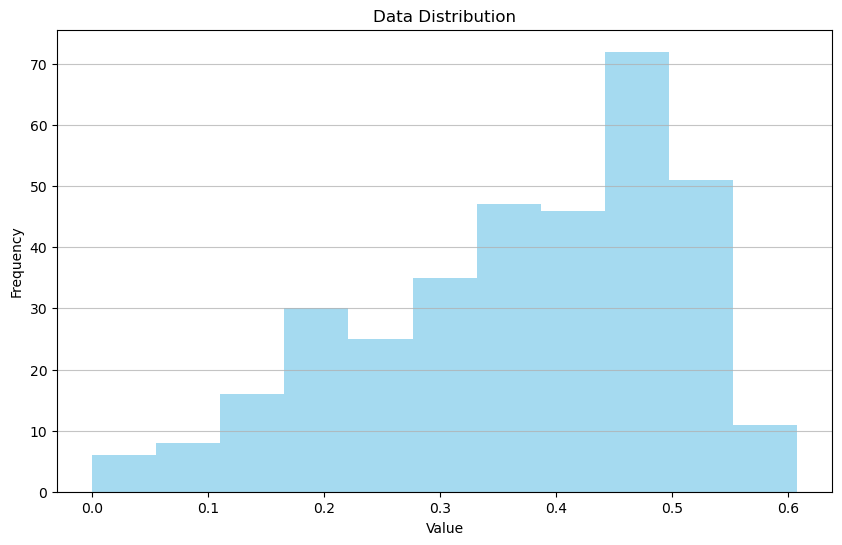

(313, 3) (1000, 3)
True: 220 313 , ratio: 0.7028753993610224


In [145]:
descriptor = "Proposed2_1"
test(descriptor, path, points, data_name)

In [146]:
descriptor = "Proposed_nolimit"
test(descriptor, path, points, data_name)

./data/data_100/Room/2/O_BC1.png
(347, 3) (1000, 3)
True: 215 347 , ratio: 0.6195965417867435


./data/data_100/Room/2/O_BC1.png


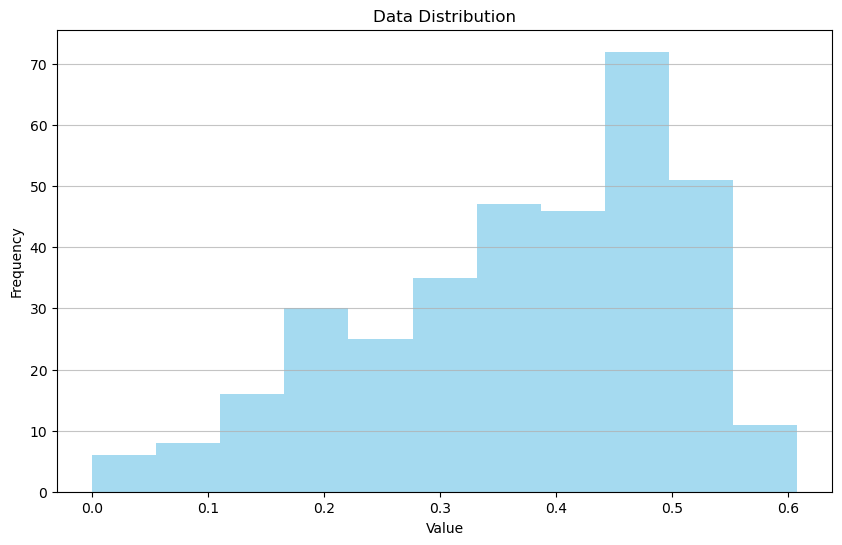

(330, 3) (1000, 3)
True: 227 330 , ratio: 0.6878787878787879


In [147]:
descriptor = "Proposed2_2"
test(descriptor, path, points, data_name)

In [78]:
descriptor = "Proposed1"
test(descriptor, path, points, data_name)

./data/data_100/Room/0/O_BCG2.png
(264, 3) (1000, 3)
True: 124 264 , ratio: 0.4696969696969697
